In [34]:
import gurobipy as gb
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as geopd
import numpy as np
import seaborn as sns

In [17]:
data = pd.read_csv('/Users/angelocapasso/Desktop/Parcel-Lockers-Location/data/Napoli.csv')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7904 entries, 0 to 7903
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   COD_RIP                7904 non-null   int64  
 1   COD_REG                7904 non-null   int64  
 2   COD_PROV_STORICO       7904 non-null   int64  
 3   COD_UTS                7904 non-null   int64  
 4   PRO_COM_T              7904 non-null   int64  
 5   PRO_COM                7904 non-null   int64  
 6   COMUNE                 7903 non-null   object 
 7   COMUNE_IT              7903 non-null   object 
 8   COMUNE_A               124 non-null    object 
 9   DEN_RIP                7904 non-null   object 
 10  DEN_REG                7904 non-null   object 
 11  DEN_UTS                7904 non-null   object 
 12  TIPO_UTS               7904 non-null   int64  
 13  CC_REG                 7904 non-null   int64  
 14  CC_UTS                 7904 non-null   int64  
 15  SIGL

In [25]:
data = data[data['DEN_UTS'] == 'Napoli']
Napoli = data[[
    "COMUNE",
    "Latitudine",
    "Longitudine",
    "POP21",
    "FAM21",
    "SUPERFICIE"
]]


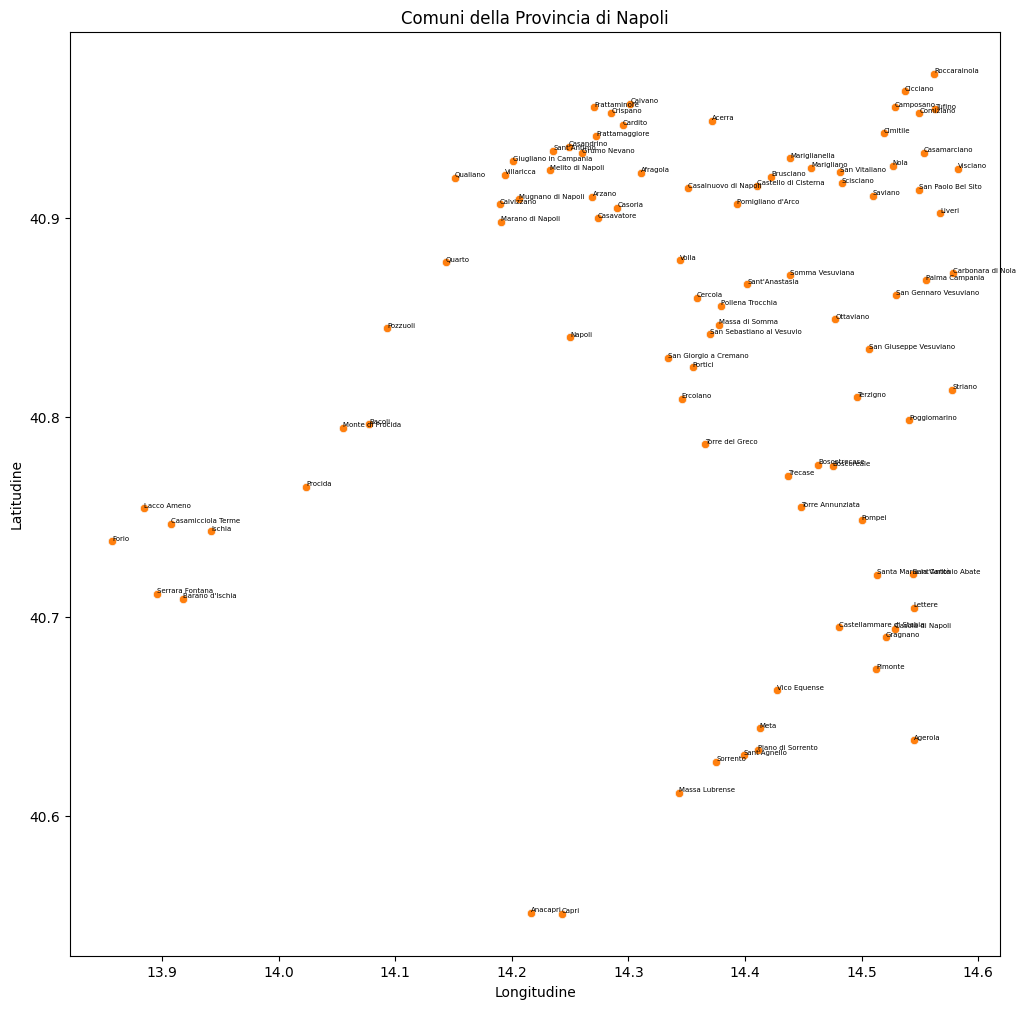

In [31]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(data = Napoli, y = 'Latitudine', x = 'Longitudine')

sns.scatterplot( data = Napoli, x = "Longitudine", y = "Latitudine" ) # Aggiunta etichette dei comuni 
for _, row in Napoli.iterrows(): plt.text( row["Longitudine"], row["Latitudine"], row["COMUNE"], fontsize=5, ha="left", va="bottom" ) 
plt.xlabel("Longitudine") 
plt.ylabel("Latitudine") 
plt.title("Comuni della Provincia di Napoli") 
plt.show()


In [36]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # raggio terrestre in metri

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


lat = Napoli["Latitudine"].values
lon = Napoli["Longitudine"].values
n = len(lat)

dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = haversine(lat[i], lon[i], lat[j], lon[j])

distances = pd.DataFrame(dist_matrix, index=Napoli["COMUNE"], columns=Napoli["COMUNE"])


In [ ]:
bins = [-1, 0, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 65000]
labels = ["0","1", "2", "3", "4", "5", "6", "7", "8"]

dist_levels = pd.DataFrame(
    pd.cut(distances.values.flatten(), bins=bins, labels=labels)
    .reshape(distances.shape),
    index=distances.index,
    columns=distances.columns
)


In [ ]:
Napoli['Domanda'] = Napoli['FAM21'] * 2 # media ordini in Italia

/var/folders/nf/0yfd5sbj61zggffg8w3y68th0000gn/T/ipykernel_62500/1439222763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Napoli['Domanda'] = Napoli['FAM21'] * 2


In [65]:
percentuali_di_compliance = {
    "0": 1,
    "1": 0.9,
    "2": 0.8,
    "3": 0.7,
    "4": 0.6,
    "5": 0.5,
    "6": 0.4,
    "7": 0.3,
    "8": 0.1
}

In [66]:
sconto = {
    "0": 0,
    "1": 0.05,
    "2": 0.05,
    "3": 0.10,
    "4": 0.10,
    "5": 0.15,
    "6": 0.15,
    "7": 0.20,
    "8": 0.20
}